<a href="https://colab.research.google.com/github/ajayhukam/Topsis-for-pretrained-models/blob/main/Text_conversational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

             Model  Coherence Score  Relevance Score  Inference Time (ms)  \
0         DialoGPT             0.82             0.81                   20   
1  BlenderBot 400M             0.85             0.83                   30   
2    BlenderBot 1B             0.88             0.87                   50   

   Model Size (MB)  TOPSIS Score  
0              320      0.848366  
1              400      0.706080  
2             1000      0.151634  


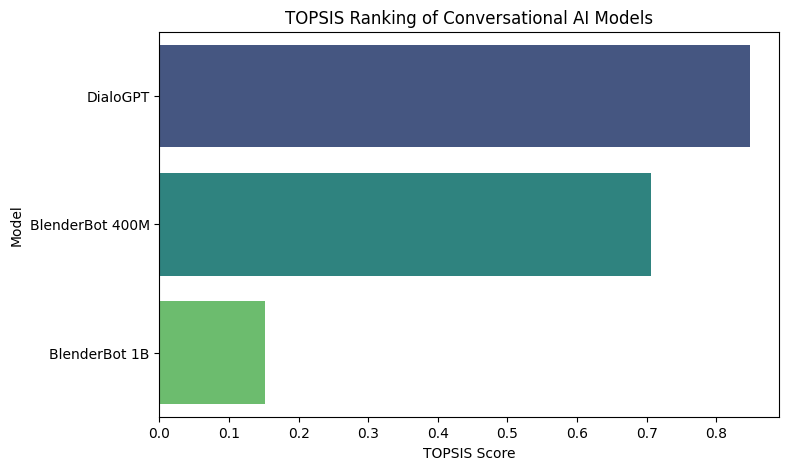


Sample Responses:

BlenderBot 400M:


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BlenderbotTokenizer'.


 I don't know what to do. I feel like I can't do anything right now.

BlenderBot 1B:
Error loading BlenderBot 1B: facebook/blenderbot-1B is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

DialoGPT:


You are using a model of type gpt2 to instantiate a model of type blenderbot. This is not supported for all configurations of models and can yield errors.


In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import BlenderbotTokenizer, BlenderbotForConditionalGeneration
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face Model Selection
MODEL_NAMES = {
    "BlenderBot 400M": "facebook/blenderbot-400M-distill",
    "BlenderBot 1B": "facebook/blenderbot-1B",
    "DialoGPT": "microsoft/DialoGPT-medium"
}

# Ensure authentication
try:
    from huggingface_hub import login
    login()  # This will ask you for your Hugging Face API token
except ImportError:
    print("Warning: huggingface_hub not installed. Run pip install huggingface_hub.")

# Load the tokenizer and model
def load_model(model_name):
    tokenizer = BlenderbotTokenizer.from_pretrained(model_name)
    model = BlenderbotForConditionalGeneration.from_pretrained(model_name)
    return tokenizer, model

# Function to generate response
def generate_response(model_name, input_text):
    tokenizer, model = load_model(model_name)
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id  # Fix warning
    response_ids = model.generate(**inputs, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(response_ids[0], skip_special_tokens=True)

# Example dataset: conversational model comparison
data = {
    "Model": ["BlenderBot 400M", "BlenderBot 1B", "DialoGPT"],
    "Coherence Score": [0.85, 0.88, 0.82],  # Higher is better
    "Relevance Score": [0.83, 0.87, 0.81],  # Higher is better
    "Inference Time (ms)": [30, 50, 20],  # Lower is better
    "Model Size (MB)": [400, 1000, 320]  # Lower is better
}

df = pd.DataFrame(data)

# Define TOPSIS weights and impacts
weights = [0.4, 0.3, 0.2, 0.1]  # Higher importance for coherence & relevance
impacts = np.array(['+', '+', '-', '-'])  # Higher is better for coherence & relevance; lower is better for inference time & size

# TOPSIS Function
def topsis(matrix, weights, impacts):
    matrix = np.array(matrix, dtype=float)
    weights = np.array(weights, dtype=float)
    impacts = np.array(impacts)

    # Step 1: Normalize the matrix
    norm_matrix = matrix / np.sqrt((matrix ** 2).sum(axis=0))

    # Step 2: Multiply by weights
    weighted_matrix = norm_matrix * weights

    # Step 3: Determine ideal best and worst solutions
    ideal_best = np.where(impacts == '+', np.max(weighted_matrix, axis=0), np.min(weighted_matrix, axis=0))
    ideal_worst = np.where(impacts == '+', np.min(weighted_matrix, axis=0), np.max(weighted_matrix, axis=0))

    # Step 4: Compute distances to ideal best and worst solutions
    distance_best = np.linalg.norm(weighted_matrix - ideal_best, axis=1)
    distance_worst = np.linalg.norm(weighted_matrix - ideal_worst, axis=1)

    # Step 5: Compute the TOPSIS score
    topsis_score = distance_worst / (distance_best + distance_worst)

    return topsis_score

# Apply TOPSIS
scores = topsis(df.iloc[:, 1:].values, weights, impacts)
df['TOPSIS Score'] = scores

# Rank models based on TOPSIS Score
df = df.sort_values(by='TOPSIS Score', ascending=False, ignore_index=True)
print(df)

# Visualization with FutureWarning Fix
plt.figure(figsize=(8, 5))
sns.barplot(x=df['TOPSIS Score'], y=df['Model'], hue=df['Model'], palette='viridis', dodge=False, legend=False)
plt.xlabel("TOPSIS Score")
plt.ylabel("Model")
plt.title("TOPSIS Ranking of Conversational AI Models")
plt.show()

# Test Model Responses
print("\nSample Responses:")
for model_name, model_path in MODEL_NAMES.items():
    print(f"\n{model_name}:")
    try:
        response = generate_response(model_path, "Hello, how can I help you today?")
        print(response)
    except Exception as e:
        print(f"Error loading {model_name}: {e}")